In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_pickle("../../../data/processed/balanced_df.pkl")

X_train, X_test, y_train, y_test = train_test_split(
    df['text'],df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

In [3]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [4]:
print(type(X_train))
print(X_train.head())

<class 'pandas.core.series.Series'>
195074                                                  nan
19952     norway foreign minister becomes president of w...
8874      us legislators to call for release of american...
29950     president obama is putting an end to inhumane ...
55935                                                   nan
Name: text, dtype: object


In [5]:
X_train = X_train.dropna()
y_train = y_train[X_train.index]

In [6]:
# Only if you want to remove literal "nan" strings too
# mask = X_train != 'nan'
# X_train = X_train[mask]
# y_train = y_train[mask]

In [7]:
X_train.head()

195074                                                  nan
19952     norway foreign minister becomes president of w...
8874      us legislators to call for release of american...
29950     president obama is putting an end to inhumane ...
55935                                                   nan
Name: text, dtype: object

In [8]:
tfidf = TfidfVectorizer(
    sublinear_tf=True,
    max_df=0.9,
    min_df=2,
    ngram_range=(1,2),
    max_features=50000
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf_s = X_test.astype(str)
X_test_tfidf = tfidf.transform(X_test_tfidf_s)

nb = MultinomialNB(alpha=0.5)
nb.fit(X_train_tfidf, y_train)

cnb = ComplementNB(alpha=0.5)
cnb.fit(X_train_tfidf, y_train)


ComplementNB(alpha=0.5)

In [9]:
y_pred = nb.predict(X_test_tfidf)
cnb_pred = cnb.predict(X_test_tfidf)

              precision    recall  f1-score   support

        FAKE       0.96      0.27      0.43     17023
        REAL       0.58      0.99      0.73     17023

    accuracy                           0.63     34046
   macro avg       0.77      0.63      0.58     34046
weighted avg       0.77      0.63      0.58     34046



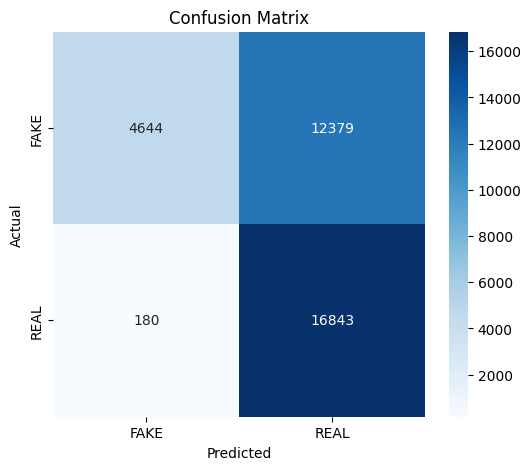

In [10]:
print(classification_report(y_test, cnb_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, cnb_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=nb.classes_,
            yticklabels=nb.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

              precision    recall  f1-score   support

        FAKE       0.96      0.27      0.43     17023
        REAL       0.58      0.99      0.73     17023

    accuracy                           0.63     34046
   macro avg       0.77      0.63      0.58     34046
weighted avg       0.77      0.63      0.58     34046



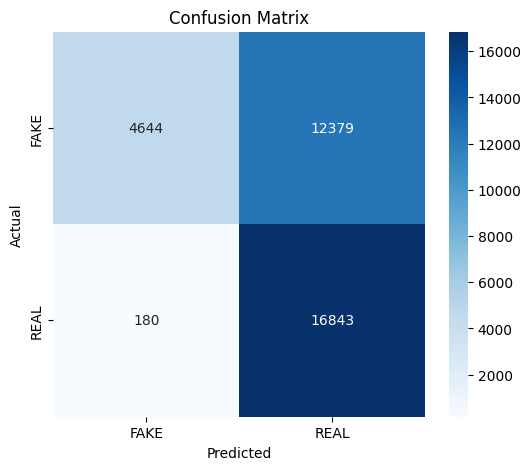

In [11]:
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=nb.classes_,
            yticklabels=nb.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## ROC CURVE AND THINGS

In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)   # "REAL" -> 1, "FAKE" -> 0
y_test_enc  = le.transform(y_test)


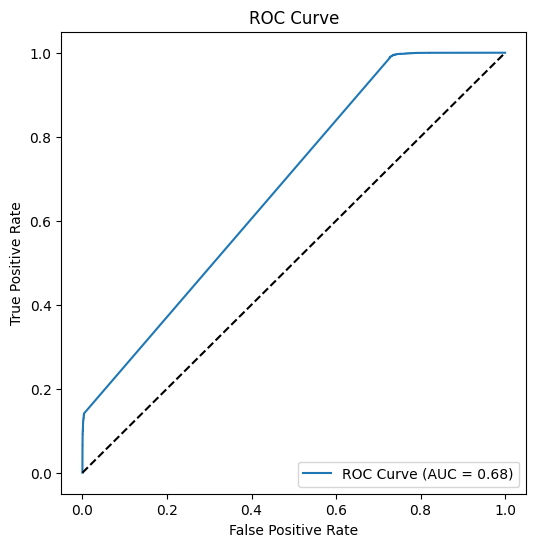

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Use decision_function (for SVM) or predict_proba (for LR, NB, etc.)
y_prob = nb.predict_proba(X_test_tfidf)[:,1]

fpr, tpr, _ = roc_curve(y_test_enc, y_prob)
roc_auc = roc_auc_score(y_test_enc, y_prob)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')  # baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


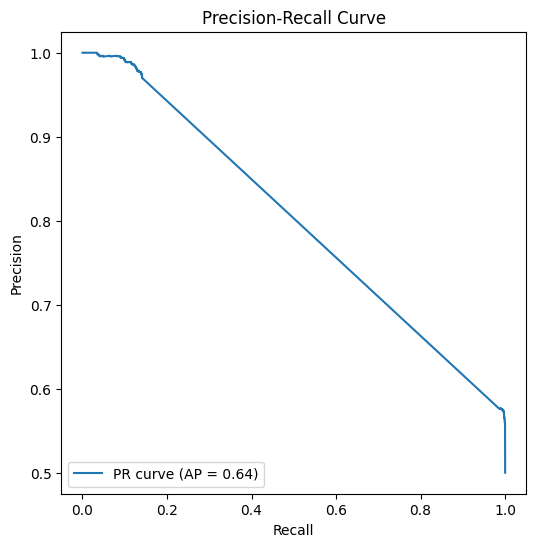

In [18]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(y_test_enc, y_prob)
ap_score = average_precision_score(y_test_enc, y_prob)

plt.figure(figsize=(6, 6))
plt.plot(recall, precision, label=f"PR curve (AP = {ap_score:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()


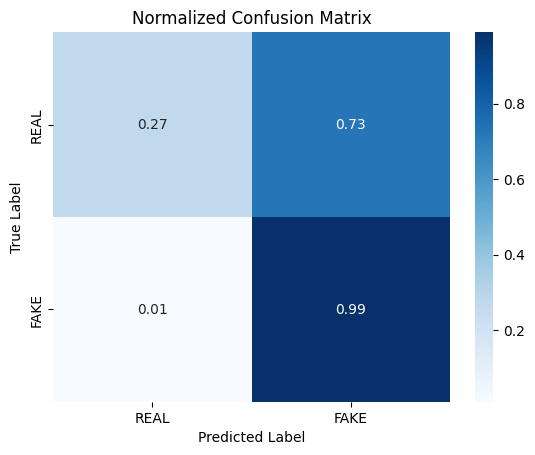

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

cm = confusion_matrix(y_test, y_pred, normalize="true")  # normalized
sns.heatmap(cm, annot=True, cmap="Blues", fmt=".2f", xticklabels=["REAL","FAKE"], yticklabels=["REAL","FAKE"])
plt.title("Normalized Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


In [20]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc = cross_val_score(nb, X_train_tfidf, y_train, cv=cv, scoring="accuracy")
f1 = cross_val_score(nb, X_train_tfidf, y_train, cv=cv, scoring="f1")
roc = cross_val_score(nb, X_train_tfidf, y_train, cv=cv, scoring="roc_auc")

print("Cross-validation results:")
print(f"Accuracy: {acc.mean():.3f} ± {acc.std():.3f}")
print(f"F1 Score: {f1.mean():.3f} ± {f1.std():.3f}")
print(f"ROC-AUC:  {roc.mean():.3f} ± {roc.std():.3f}")


c:\Users\kknah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\kknah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\kknah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "c:\Users\kknah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kknah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_response.py", line 207, in _get_response_values
  

Cross-validation results:
Accuracy: 0.629 ± 0.003
F1 Score: nan ± nan
ROC-AUC:  0.680 ± 0.003
